# Solow model

In [25]:
from IPython.core.display import HTML
from IPython import utils  
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())
#http://moderndata.plot.ly/custom-styling-for-ipython-notebooks-with-3-lines-of-code/
###HTML("""
#<style>
#// add your CSS styling here
#open(os.path.join(base,'solowpy/solowpy.css'),'r').read()
#</style>
#""")


.. _`Solow (1956)`:  http://piketty.pse.ens.fr/files/Solow1956.pdf

Quick summary of Solow (1956)
=============================

The following summary of the Solow model of economic growth largely follows `Romer (2011)`_.

`Romer (2011)`: http://highered.mheducation.com/sites/0073511374/index.html

### The production function


The Solow model of economic growth focuses on the behavior of four
variables: output, `Y`, capital, `K`, labor, `L`, and knowledge (or technology
or the "effectiveness of labor"), `A`. At each point in time the economy has
some amounts of capital, labor, and knowledge that can be combined to produce
output according to some production function, `F`.



$$Y(t) = F(K(t), A(t)L(t))$$

where `t` denotes time.

#### The evolution of the inputs to production

The initial levels of capital, :math:$K_0$, labor, :math:$L_0$, and technology,
$A_0$, are taken as given. Labor and technology are assumed to grow at
constant rates:


$$\dot{A}(t) = gA(t)$$
$$\dot{L}(t) = nL(t)$$

where the rate of technological progrss, `g`, and the population growth rate,
`n`, are exogenous parameters.

Output is divided between consumption and investment. The fraction of output
devoted to investment, `0 < s < 1`, is exogenous and constant. One unit
of output devoted to investment yields one unit of new capital. Capital is
assumed to decpreciate at a rate  $0\le \delta$. Thus aggregate capital
stock evolves according to



$$\dot{K}(t) = sY(t) - \delta K(t).$$

Although no restrictions are placed on the rates of technological progress and
population growth, the sum of `g`, `n`, and :math: $\delta$ is assumed to be
positive.

#### The dynamics of the model


Because the economy is growing over time (due to exogenous technological
progress and population growth) it is useful to focus on the behavior of
capital stock per unit of effective labor


    
$$k \equiv K/AL.$$

Applying the chain rule to the equation of motion for capital stock yields (after a
bit of algebra!) an equation of motion for capital stock per unit of effective
labor.


$$\dot{k}(t) = s f(k) - (g + n + \delta)k(t)$$

That's it! The Solow model of economic growth reduced to a single non-linear ordinary differential equation.

https://github.com/solowPy/solowPy



In [3]:
#from IPython.html.widgets import fixed
from ipywidgets import interact, FloatSlider, IntSlider, fixed

In [2]:
# Lots of different places that widgets could come from...
try:
    from ipywidgets import interact, FloatSlider, IntSlider
except ImportError:
    try:
        from IPython.html.widgets import interact, FloatSlider, IntSlider
    except ImportError:
        try:
            from IPython.html.widgets import (interact,
                                              FloatSliderWidget as FloatSlider,
                                              IntSliderWidget as IntSlider)
        except ImportError:
            pass

In [4]:
import numpy as np
from sympy import *

from IPython.display import *
import matplotlib.pyplot as plt
%matplotlib inline 
init_printing(use_latex=True)

import seaborn as sns


import pandas as pd

import quantecon as qe
import solowpy



In [5]:
init_printing(use_latex=True) 

## 0.1 The basic Solow growth model
The Solow model can be reduced down to a single non-linear differential equation and associated initial condition describing the time evolution of capital stock (per unit effective labor), $k(t)$.

$$ \dot{k}(t) = sf(k(t)) - (n + g + \delta)k(t),\ k(t) = k_0 \tag {0.1.1} $$

The parameter $0 < s < 1$ is the fraction of output invested and the parameters $n, g, \delta$ are the rates of population growth, technological progress, and depreciation of physical capital. The intensive form of the production function $f$ is assumed to be to be strictly concave with 

$$ f(0) = 0,\ lim_{k\rightarrow 0}\ f' = \infty,\ lim_{k\rightarrow \infty}\ f' = 0. \tag{0.1.2} $$ 

A common choice for the function $f$ which satisfies the above conditions is known as the Cobb-Douglas production function.

$$ f(k(t)) = k(t)^{\alpha} $$

Assuming a Cobb-Douglas functional form for $f$ also makes the model analytically tractable (and thus contributes to the typical economics student's belief that all such models "must" have an analytic solution). [Sato 1963](http://www.jstor.org/stable/2296026) showed that the solution to the model under the assumption of Cobb-Douglas production is

$$ k(t) = \Bigg[\bigg(\frac{s}{n+g+\delta}\bigg)\bigg(1 - e^{-(n+g+\delta)(1-\alpha)t}\bigg)+ k_0^{1-\alpha}e^{-(n+g+\delta)(1-\alpha)t}\Bigg]^{\frac{1}{1-\alpha}}. \tag{0.1.3} $$

A notable property of the Solow model with Cobb-Douglas production is that the model predicts that the shares of real income going to capital and labor should be constant. Denoting capital's share of income as $\alpha_K(k)$, the model predicts that 

$$ \alpha_K(k(t)) \equiv \frac{\partial \ln f(k(t))}{\partial \ln k(t)} = \alpha \tag{0.1.4} $$

Note that the prediction is that factor shares are constant along both the balanced growth path *and* during the disequilibrium transient (i.e., the period in which $k(t)$ is varying).  We can test this implication of the model using data from the newest version of the [Penn World Tables (PWT)](http://www.rug.nl/research/ggdc/data/penn-world-table). 

In [6]:
# define model variables
A, K, L = symbols('A, K, L')

# define production parameters
alpha, sigma = symbols('alpha, sigma')

# define a production function
cobb_douglas_output = K**alpha * (A * L)**(1 - alpha)

#rho = (sigma - 1) / sigma
#ces_output = (alpha * K**rho + (1 - alpha) * (A * L)**rho)**(1 / rho)

In [7]:
cobb_douglas_output

In [8]:
# cobb_douglas
display(Latex('$Y = ' + str(latex(cobb_douglas_output) + '$')))

<IPython.core.display.Latex object>

In [9]:
cobb_douglas_params = {'A0': 1.0, 'L0': 1.0, 'g': 0.02, 'n': 0.03, 's': 0.15,
                       'delta': 0.05, 'alpha': 0.33}
# give model parameters
cobb_douglas_model = solowpy.Model(output=cobb_douglas_output,
                                 params=cobb_douglas_params)

## 1.3 Other attributes of the `solow.Model` class

### The intensive form of the production function

The assumption of constant returns to scale allows us to work with the intensive form of the aggregate production function, $F$. Defining $c=1/AL$ one can write

$$ F\bigg(\frac{K}{AL}, 1\bigg) = \frac{1}{AL}F(A, K, L) \tag{1.3.1} $$

Defining $k=K/AL$ and $y=Y/AL$ to be capital per unit effective labor and output per unit effective labor, respectively, the intensive form of the production function can be written as

$$ y = f(k). \tag{1.3.2}$$

Additional assumptions are that $f$ satisfies $f(0)=0$, is concave (i.e., $f'(k) > 0, f''(k) < 0$), and satisfies the Inada conditions: $\lim_{k \rightarrow 0} = \infty$ and $\lim_{k \rightarrow \infty} = 0$. The <cite data-cite="inada1964">(Inada, 1964)</cite> conditions are sufficient (but not necessary!) to ensure that the time path of capital per effective worker does not explode. Much of the above information is actually taken straight from the docstring for the `solow.Model.intensive_output` attribute.

In [10]:

cobb_douglas_model.intensive_output

In [11]:
cobb_douglas_model

In [12]:
print(r"f(x) =", cobb_douglas_model.intensive_output )
display(Latex('$f(x) = ' + str(latex(cobb_douglas_model.intensive_output) + '$')))

('f(x) =', 1.0**(-alpha + 1)*k**alpha)


<IPython.core.display.Latex object>

One can numerically evaluate the intensive output for various values of capital stock (per unit effective labor) as follows...

In [13]:
cobb_douglas_model.evaluate_intensive_output(np.linspace(1.0, 10.0, 25))

array([ 1.        ,  1.11081028,  1.2028253 ,  1.28241458,  1.35306981,
        1.41693683,  1.47543985,  1.52957805,  1.58008262,  1.6275066 ,
        1.6722796 ,  1.71474276,  1.75517202,  1.79379413,  1.8307979 ,
        1.86634248,  1.90056336,  1.93357699,  1.96548422,  1.99637311,
        2.026321  ,  2.05539625,  2.0836596 ,  2.11116532,  2.13796209])

### The marginal product of capital

The marginal product of capital is defined as follows:

$$ \frac{\partial F(K, AL)}{\partial K} \equiv f'(k) \tag{1.3.3}$$

where $k=K/AL$ is capital stock (per unit effective labor).

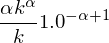

In [14]:
cobb_douglas_model.marginal_product_capital

One can numerically evaluate the marginal product of capital for various values of capital stock (per unit effective labor) as follows...

In [15]:
cobb_douglas_model.evaluate_mpk(np.linspace(1.0, 10.0, 25))

array([ 0.33      ,  0.26659447,  0.22681849,  0.19915144,  0.17860521,
        0.16263971,  0.14981389,  0.13924435,  0.13035682,  0.1227605 ,
        0.11617942,  0.1104127 ,  0.10531032,  0.1007578 ,  0.09666613,
        0.09296498,  0.08959799,  0.08651938,  0.08369159,  0.08108346,
        0.07866893,  0.076426  ,  0.07433596,  0.07238281,  0.07055275])

### Equation of motion for capital (per unit effective labor)
Because the economy is growing over time due to technological progress, $g$, and population growth, $n$, it makes sense to focus on the capital stock per unit effective labor, $k$, rather than aggregate physical capital, $K$. Since, by definition, $k=K/AL$, we can apply the chain rule to the time derative of $k$.

\begin{align}
\dot{k}(t) =& \frac{\dot{K}(t)}{A(t)L(t)} - \frac{K(t)}{[A(t)L(t)]^2}\bigg[\dot{A}(t)L(t) + \dot{L}(t)A(t)\bigg] \\
=& \frac{\dot{K}(t)}{A(t)L(t)} - \bigg(\frac{\dot{A}(t)}{A(t)} + \frac{\dot{L}(t)}{L(t)}\bigg)\frac{K(t)}{A(t)L(t)} \tag{1.3.4}
\end{align}

By definition, $k=K/AL$, and by assumption $\dot{A}/A$ and $\dot{L}/L$ are $g$ and $n$ respectively. Aggregate capital stock evolves according to

$$ \dot{K}(t) = sF(K(t), A(t)L(t)) - \delta K(t). \tag{1.3.5}$$

Substituting these facts into the above equation yields the equation of
motion for capital stock (per unit effective labor).

\begin{align}
\dot{k}(t) =& \frac{sF(K(t), A(t)L(t)) - \delta K(t)}{A(t)L(t)} - (g + n)k(t) \\
=& \frac{sY(t)}{A(t)L(t)} - (g + n + \delta)k(t) \\
=& sf(k(t)) - (g + n + \delta)k(t) \tag{1.3.6}
\end{align}

The above information is available for reference in the docstring for the `solow.Model.k_dot` attribute.

In [16]:
cobb_douglas_model.k_dot

One can numerically evaluate the equation of motion for capital (per unit effective labor) for various values of capital stock (per unit effective labor) as follows...

In [17]:
cobb_douglas_model.evaluate_k_dot(np.linspace(1.0, 10.0, 25))

array([ 0.05      ,  0.02912154,  0.0054238 , -0.02013781, -0.04703953,
       -0.07495947, -0.10368402, -0.13306329, -0.16298761, -0.19337401,
       -0.22415806, -0.25528859, -0.2867242 , -0.31843088, -0.35038031,
       -0.38254863, -0.4149155 , -0.44746345, -0.48017737, -0.51304403,
       -0.54605185, -0.57919056, -0.61245106, -0.6458252 , -0.67930569])

In [18]:
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

In [18]:
#import pypwt

# 2. Computing the steady state

Traditionally, most analysis of the Solow model focuses almost excusively on the long run steady state of the model. Recall that the steady state of the Solow model is the value of capital stock (per unit effective labor) that solves

$$ 0 = sf(k^*) - (g + n + \delta)k^*. \tag{2.0.1} $$

In words: in the long-run, capital stock (per unit effective labor) converges to the value that balances actual investment, $sf(k)$, with effective depreciation, $(g + n + \delta)$. Given the assumption made about the aggregate production technology, $F$, and its intensive form, $f$, there is always a unique value $k^* >0$ satisfying equation 2.0.1.

## 2.1 Analytic results
For many (all?) of the commonly used functional forms for $F$ one can easily derive a closed-form expression for the steady state value of capital stock (per unit effective labor). For example, assuming $F$ is Cob Douglas (CD), the analytical solution for $k^*$ is

$$ k^* = \left[\frac{s}{({g+n+\delta})}\right]^{\frac{1}{1-\alpha}} \tag{2.1.0} $$

This analytic solution is available via the `steady_state` attribute.

In [19]:
cobb_douglas_model.steady_state

In [20]:
k_star, result = cobb_douglas_model.find_steady_state(1e-6, 1e6, 
                                                      method='bisect', full_output=True)

In [21]:
print("The steady-state value is {}".format(k_star))
print("Did the bisection algorithm coverge? {}".format(result.converged))

The steady-state value is 1.8315668508
Did the bisection algorithm coverge? True


### Static example:
Creating a static plot of the classic Solow diagram is done as follows.

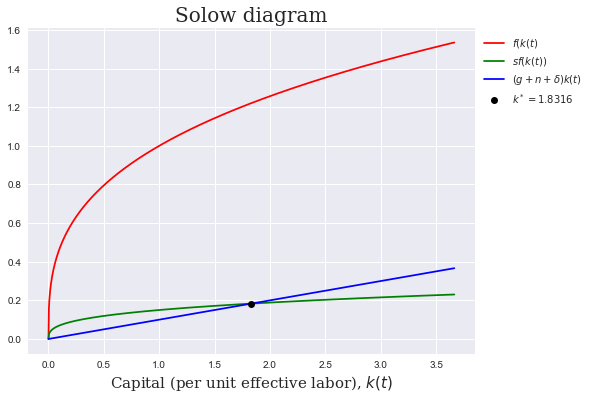

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
cobb_douglas_model.plot_solow_diagram(ax)
fig.show()

## Interactive example:
All of the various plotting methods can be made interactive using IPython widgets. To construct an IPython widget we need the following additional `import` statements.

In [21]:
from IPython.html.widgets import fixed, interact

from ipywidgets import fixed,interact, FloatSlider, IntSlider

In [37]:
cobb_douglas_params = {'A0': 1.0, 'L0': 1.0, 'g': 0.06, 'n': 0.03, 's': 0.33,
                       'delta': 0.05, 'alpha': 0.33}
# give model parameters
cobb_douglas_model = solowpy.Model(output=cobb_douglas_output,
                                 params=cobb_douglas_params)

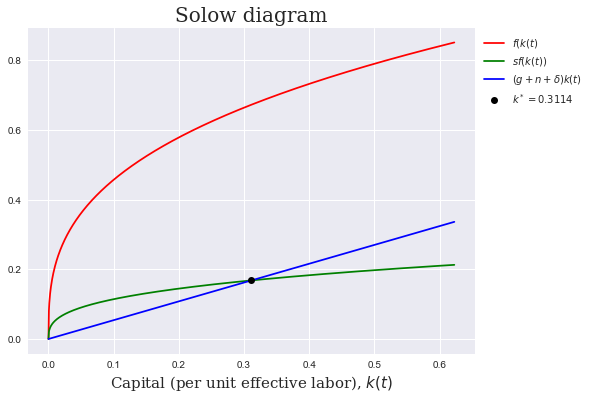

In [38]:
# wrap the static plotting code in a function 
def interactive_solow_diagram(model, **params):
    """Interactive widget for the factor shares."""
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    model.plot_solow_diagram(ax, Nk=1000, **params)
    
# define some widgets for the various parameters
eps = 1e-2
technology_progress_widget = FloatSlider(min=-0.05, max=0.05, step=eps, value=0.02)
population_growth_widget = FloatSlider(min=-0.05, max=0.05, step=eps, value=0.02)
savings_widget = FloatSlider(min=eps, max=1-eps, step=eps, value=0.5)
output_elasticity_widget = FloatSlider(min=eps, max=1.0, step=eps, value=0.5)
depreciation_widget = FloatSlider(min=eps, max=1-eps, step=eps, value=0.5)
elasticity_substitution_widget = FloatSlider(min=eps, max=10.0, step=0.01, value=1.0+eps)

# create the widget for CD!
interact(interactive_solow_diagram, 
         model=fixed(cobb_douglas_model),
         g=technology_progress_widget,
         n=population_growth_widget,
         s=savings_widget, 
         alpha=output_elasticity_widget,
         delta=depreciation_widget,
         #sigma=elasticity_substitution_widget,
         )

## 3.1 Intensive production function
Creating an interactive plot of the intensive production function is done as follows.

<function __main__.interactive_intensive_output>

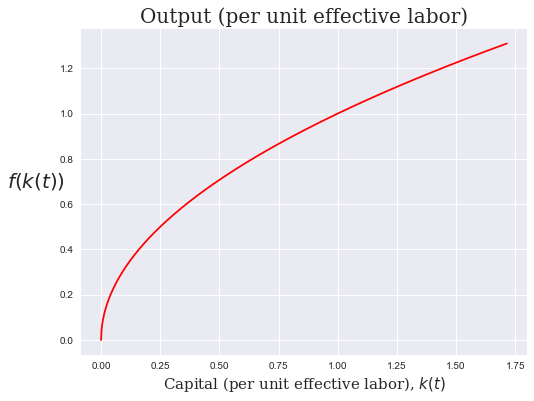

In [24]:
def interactive_intensive_output(model, **params):
    """Interactive widget for the intensive production function."""
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    model.plot_intensive_output(ax, Nk=1000, **params)
    
# define some widgets for the various parameters
eps = 1e-2
output_elasticity_widget = FloatSlider(min=eps, max=1-eps, step=0.1, value=0.5)
elasticity_substitution_widget = FloatSlider(min=eps, max=10.0, step=0.5, value=1.0+eps)

# create the interactive plot
interact(interactive_intensive_output,
         model=fixed(cobb_douglas_model),
         alpha=output_elasticity_widget,
         #sigma=elasticity_substitution_widget
         )

## 3.2  Factor shares
Creating an interactive plot of factor shares for capital and labor is done as follows.

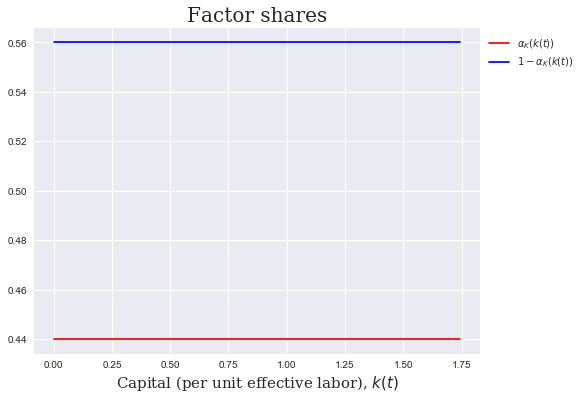

In [27]:
def interactive_factor_shares(model, **params):
    """Interactive widget for the factor shares."""
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    model.plot_factor_shares(ax, Nk=1000, **params)
    
# define some widgets for the various parameters
eps = 1e-2
technology_progress_widget = FloatSlider(min=-0.05, max=0.05, step=eps, value=0.02)
population_growth_widget = FloatSlider(min=-0.05, max=0.05, step=eps, value=0.02)
savings_widget = FloatSlider(min=eps, max=1-eps, step=eps, value=0.5)
output_elasticity_widget = FloatSlider(min=eps, max=1.0-eps, step=eps, value=0.5)
depreciation_widget = FloatSlider(min=eps, max=1-eps, step=eps, value=0.5)
elasticity_substitution_widget = FloatSlider(min=eps, max=10.0, step=0.5, value=1.0+eps)

# create the widget!
interact(interactive_factor_shares, 
         model=fixed(cobb_douglas_model),
         g=technology_progress_widget,
         n=population_growth_widget,
         s=savings_widget, 
         alpha=output_elasticity_widget,
         delta=depreciation_widget,
         #sigma=elasticity_substitution_widget,
         )

## 3.4 Phase Diagram
Creating an interactive plot of the phase diagram for the Solow model is done as follows.

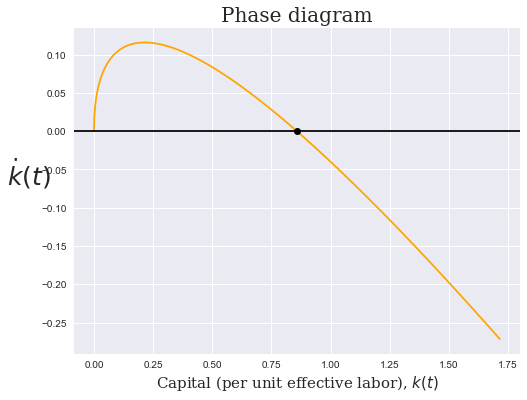

In [28]:
def interactive_phase_diagram(model, **params):
    """Interactive widget for the phase diagram."""
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    model.plot_phase_diagram(ax, Nk=1000, **params)
    
# define some widgets for the various parameters
eps = 1e-2
technology_progress_widget = FloatSlider(min=-0.05, max=0.05, step=eps, value=0.02)
population_growth_widget = FloatSlider(min=-0.05, max=0.05, step=eps, value=0.02)
savings_widget = FloatSlider(min=eps, max=1-eps, step=eps, value=0.5)
output_elasticity_widget = FloatSlider(min=eps, max=1-eps, step=eps, value=0.5)
depreciation_widget = FloatSlider(min=eps, max=1-eps, step=eps, value=0.5)
elasticity_substitution_widget = FloatSlider(min=eps, max=10.0, step=0.5, value=1.0+eps)


# create the widget!
phase_diagram_widget = interact(interactive_phase_diagram, 
                                model=fixed(cobb_douglas_model),
                                g=technology_progress_widget,
                                n=population_growth_widget,
                                s=savings_widget, 
                                alpha=output_elasticity_widget,
                                delta=depreciation_widget,
                                #sigma=elasticity_substitution_widget
                                )

# 4. Solving the Solow model

Solving the Solow model requires efficiently and accurately approximating the solution to a non-linear ordinary differential equation (ODE) with a given initial condition (i.e., an non-linear initial value problem). 

## 4.1 Solow model as an initial value problem

The Solow model with can be formulated as an initial value problem (IVP) as follows.

$$ \dot{k}(t) = sf(k(t)) - (g + n + \delta)k(t),\ t\ge t_0,\ k(t_0) = k_0 \tag{4.1.0} $$

The `quantecon` library has its own module `quantecon.ivp` for solving initial value problems of this form using [finite difference methods](http://en.wikipedia.org/wiki/Finite_difference_method). Upon creation of our instance of the `solow.Model` class, an instance of the `quantecon.ivp.IVP` class was created and stored as an attribute of our model...·

In [29]:
# need to specify some initial conditions
t0, k0 = 0.0, 0.5
numeric_soln = cobb_douglas_model.ivp.solve(t0, k0, T=100, integrator='dopri5')

We can plot the finite-difference approximation of the solution as follows...

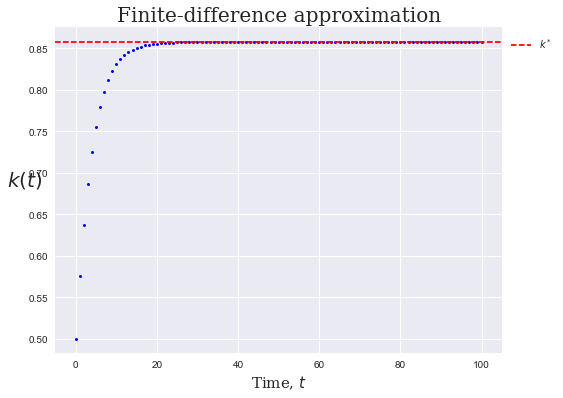

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

# plot the finite-difference-approximation
ax.plot(numeric_soln[:,0], numeric_soln[:,1], 'bo', markersize=3.0)

# equilibrium value of capital stock (per unit effective labor)
k_star = cobb_douglas_model.steady_state
ax.axhline(k_star, linestyle='dashed', color='r', label='$k^*$')

# axes, labels, title, etc
ax.set_xlabel('Time, $t$', fontsize=15, family='serif')
ax.set_ylabel('$k(t)$', rotation='horizontal', fontsize=20, family='serif')
ax.set_title('Finite-difference approximation',
             fontsize=20, family='serif')
ax.legend(loc=0, frameon=False, bbox_to_anchor=(1.0, 1.0))
ax.grid('on')

plt.show()

## 4.2 Analytic methods

### 4.2.1 Analytic solution for a model with Cobb-Douglas production

The Solow model with Cobb-Douglas production happens to have a completely [general analytic solution](https://github.com/davidrpugh/numerical-methods/raw/master/labs/lab-1/solow-analytic-solution.pdf):

$$ k(t) = \left[\left(\frac{s}{n+g+\delta}\right)\left(1 -  e^{-(n + g + \delta) (1-\alpha) t}\right) + k_0^{1-\alpha}e^{-(n + g + \delta) (1-\alpha) t}\right]^{\frac{1}{1-\alpha}} \tag{4.2.0}$$

This analytic result is available via the `analytic_solution` method of the `solow.CobbDouglasModel` class.

In [42]:
# define model parameters
cobb_douglas_params = {'A0': 1.0, 'L0': 1.0, 'g': 0.02, 'n': 0.03, 's': 0.15,
                      'delta': 0.05, 'alpha': 0.33}

# create an instance of the solow.Model class
cobb_douglas_model = solowpy.CobbDouglasModel(params=cobb_douglas_params)

In [43]:
# specify some initial condition
k0 = 0.5 * cobb_douglas_model.steady_state

# grid of t values for which we want the value of k(t)
ti = np.linspace(0, 100, 10)

# generate a trajectory!
cobb_douglas_model.analytic_solution(ti, k0)

array([[   0.        ,    0.91578343],
       [  11.11111111,    1.37081903],
       [  22.22222222,    1.60723533],
       [  33.33333333,    1.72380474],
       [  44.44444444,    1.78011125],
       [  55.55555556,    1.80706521],
       [  66.66666667,    1.81991504],
       [  77.77777778,    1.8260292 ],
       [  88.88888889,    1.82893579],
       [ 100.        ,    1.83031695]])

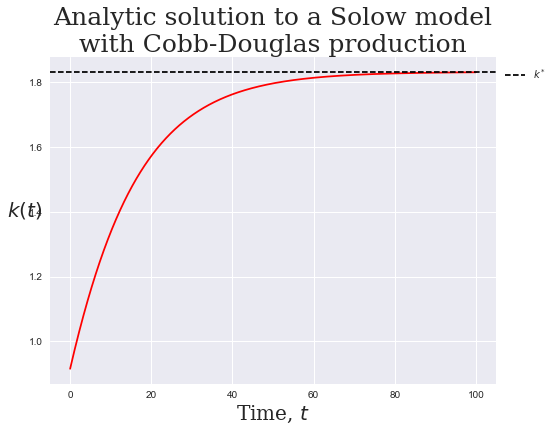

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

# compute the solution
ti = np.linspace(0, 100, 1000)
analytic_traj = cobb_douglas_model.analytic_solution(ti, k0)

# plot this trajectory
ax.plot(ti, analytic_traj[:,1], 'r-')

# equilibrium value of capital stock (per unit effective labor)
ax.axhline(cobb_douglas_model.steady_state, linestyle='dashed',
           color='k', label='$k^*$')

# axes, labels, title, etc
ax.set_xlabel('Time, $t$', fontsize=20, family='serif')
ax.set_ylabel('$k(t)$', rotation='horizontal', fontsize=20, family='serif')
ax.set_title('Analytic solution to a Solow model\nwith Cobb-Douglas production',
             fontsize=25, family='serif')
ax.legend(loc=0, frameon=False, bbox_to_anchor=(1.0, 1.0))
ax.grid('on')

plt.show()

# 5. Impulse response functions

Impulse response functions (IRFs) are a standard tool for analyzing the short run dynamics of dynamic macroeconomic models, such as the Solow growth model, in response to an exogenous shock. The `solow.impulse_response.ImpulseResponse` class has several attributes and methods for generating and analyzing impulse response functions. 

In [31]:
# 50% increase in the current savings rate...
cobb_douglas_model.irf.impulse = {'s': 1.5 * cobb_douglas_model.params['s']}

# in efficiency units...
cobb_douglas_model.irf.kind = 'efficiency_units'

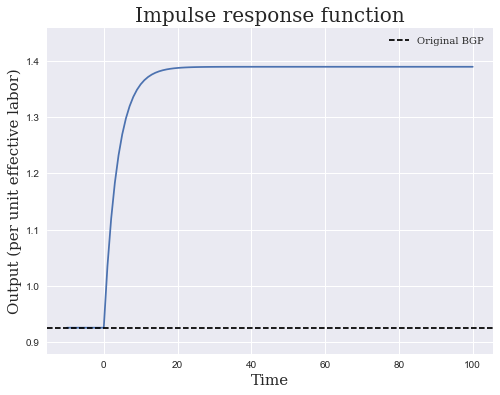

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
cobb_douglas_model.irf.plot_impulse_response(ax, variable='output')
plt.show()

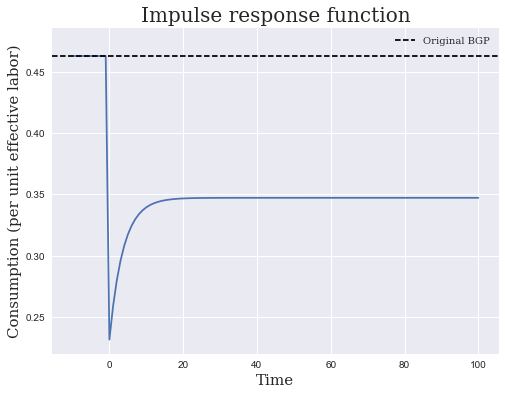

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
cobb_douglas_model.irf.plot_impulse_response(ax, variable='consumption')
plt.show()

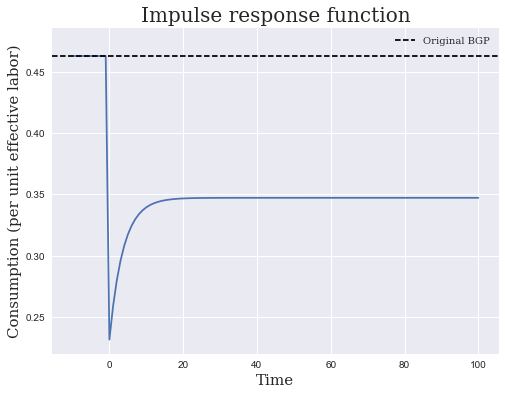

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
cobb_douglas_model.irf.plot_impulse_response(ax, variable='consumption')
plt.show()

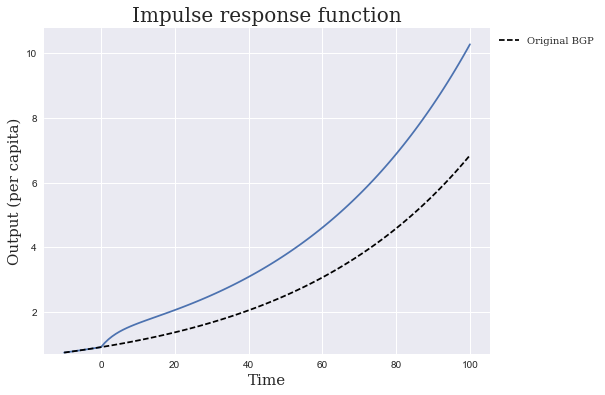

In [32]:
# in per_capita ...
cobb_douglas_model.irf.kind = 'per_capita'

fig, ax = plt.subplots(1, 1, figsize=(8,6))
cobb_douglas_model.irf.plot_impulse_response(ax, variable='output')
plt.show()

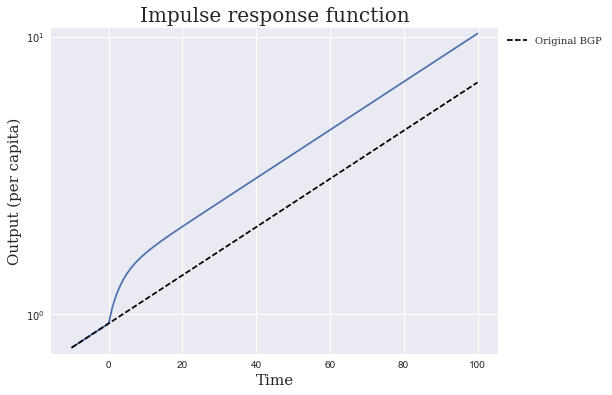

In [33]:
# in per_capita ...
cobb_douglas_model.irf.kind = 'per_capita'

fig, ax = plt.subplots(1, 1, figsize=(8,6))
cobb_douglas_model.irf.plot_impulse_response(ax, variable='output', log=True)
plt.show()

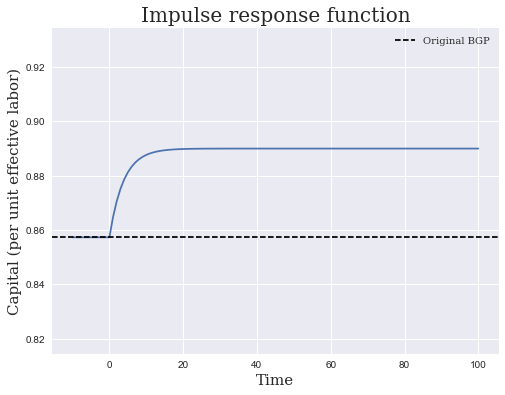

In [33]:
def interactive_impulse_response(model, shock, param, variable, kind, log_scale):
    """Interactive impulse response plotting tool."""    
    # specify the impulse response
    model.irf.impulse = {param: shock * model.params[param]}
    model.irf.kind = kind
    
    # create the plot
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    model.irf.plot_impulse_response(ax, variable=variable, log=log_scale)
    

irf_widget = interact(interactive_impulse_response, 
                      model=fixed(cobb_douglas_model),
                      shock = FloatSlider(min=0.1, max=5.0, step=0.1, value=0.5),
                      param = ['g', 'n', 's', 'alpha', 'delta'], # 'sigma'],
                      variable=['capital', 'output', 'consumption', 'investment'],
                      kind=['efficiency_units', 'per_capita', 'levels'],
                      log_scale=False,
                      )

### 4.2.2 Linearized solution to general model

In general there will not be closed-form solutions for the Solow model. The standard approach to obtaining general analytical results for the Solow model is to linearize the equation of motion for capital stock (per unit effective labor). Linearizing the equation of motion of capital (per unit effective labor) amounts to taking a first-order [Taylor approximation](http://en.wikipedia.org/wiki/Taylor_series) of equation 4.1.0 around its long-run equilibrium $k^*$:

$$ \dot{k}(t) \approx -\lambda (k(t) - k^*),\ t \ge t_0,\ k(t_0)=k_0 \tag{4.2.1}$$

where the *speed of convergence*, $\lambda$, is defined as 

$$ \lambda = -\frac{\partial \dot{k}(k(t))}{\partial k(t)}\bigg|_{k(t)=k^*} \tag{4.2.2} $$

The solution the the linear differential equation 4.2.1 is

$$ k(t) = k^* + e^{-\lambda t}(k_0 - k^*). \tag{4.2.3} $$

To complete the solution it remains to find an expression for the speed of convergence $\lambda$:

\begin{align}
    \lambda \equiv -\frac{\partial \dot{k}(k(t))}{\partial k(t)}\bigg|_{k(t)=k^*} =& -[sf'(k^*) - (g + n+ \delta)] \\
    =& (g + n+ \delta) - sf'(k^*) \\
    =& (g + n + \delta) - (g + n + \delta)\frac{k^*f'(k^*)}{f(k^*)} \\
    =& (1 - \alpha_K(k^*))(g + n + \delta) \tag{4.2.4}
\end{align}
where the elasticity of output with respect to capital, $\alpha_K(k)$, is

$$\alpha_K(k) = \frac{k^*f'(k^*)}{f(k^*)}. \tag{4.2.5}$$

# 6. The Solow model, declining labor's share, and secular stagnation

Recently there has been much discussion about the reasons for the [Elsby (2013)](http://www.brookings.edu/~/media/Projects/BPEA/Fall%202013/2013b_elsby_labor_share.pdf) has a nice paper that looks at the decline of labor share in the U.S.; as well as much debat about whether or not developed economes are experiencing some sort of [secular stagnation](http://www.economist.com/blogs/buttonwood/2014/11/secular-stagnation) more generally.

In [ ]:
def awesome_interactive_plot(model, iso3_code, **params):
    """Interactive widget for the my awesome plot."""
    
    # extract the relevant data
    tmp_data = pwt.major_xs(iso3_code)
    actual_labor_share = tmp_data.labsh.values
    actual_capital_share = 1 - tmp_data.labsh
    
    output = tmp_data.rgdpna
    capital = tmp_data.rkna
    labor = tmp_data.emp
    
    # need to update params
    model.params.update(params)
    
    # get new initial condition
    implied_technology = model.evaluate_solow_residual(output, capital, labor)
    k0 = tmp_data.rkna[0] / (implied_technology[0] * labor[0])
    
    # finite difference approximation
    T = actual_labor_share.size
    soln = model.ivp.solve(t0, k0, T=T, integrator='dopri5')
    
    # get predicted labor share
    predicted_capital_share = model.evaluate_output_elasticity(soln[:,1])
    predicted_labor_share = 1 - predicted_capital_share
        
    # get predicted output per unit labor
    predicted_intensive_output = model.evaluate_intensive_output(soln[:,1])
    technology = implied_technology[0] * np.exp(ces_model.params['g'] * soln[:,0])
    predicted_output_per_unit_labor = predicted_intensive_output * technology

    # make the plots!
    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    axes[0].plot(soln[:,0], predicted_labor_share, 'b')
    axes[0].plot(soln[:,0], predicted_capital_share, 'g')
    axes[0].plot(actual_labor_share)
    axes[0].plot(actual_capital_share)    
    axes[0].set_xlabel('Time, $t$', fontsize=15, family='serif')
    axes[0].set_ylim(0, 1)
    axes[0].set_title('Labor share of income in {}'.format(iso3_code),
                      fontsize=20, family='serif')
    axes[0].legend(loc=0, frameon=False, bbox_to_anchor=(1.0, 1.0))
    
    axes[1].set_xlabel('Time, $t$', fontsize=15, family='serif')
    axes[1].set_title('Growth rate of Y/L in {}'.format(iso3_code),
                      fontsize=20, family='serif')
    axes[1].legend(loc=0, frameon=False, bbox_to_anchor=(1.0, 1.0))
    axes[1].plot(soln[1:,0], np.diff(np.log(predicted_output_per_unit_labor)),
                 'b', markersize=3.0)
    axes[1].plot(np.log(output / labor).diff().values)

    
# define some widgets for the various parameters
technology_progress_widget = FloatSlider(min=-0.05, max=0.05, step=5e-3, value=0.01)
population_growth_widget = FloatSlider(min=-0.05, max=0.05, step=5e-3, value=0.01)
savings_widget = FloatSlider(min=eps, max=1-eps, step=5e-3, value=0.2)
output_elasticity_widget = FloatSlider(min=eps, max=1.0, step=5e-3, value=0.15)
depreciation_widget = FloatSlider(min=eps, max=1-eps, step=5e-3, value=0.02)
elasticity_substitution_widget = FloatSlider(min=eps, max=10.0, step=1e-2, value=2.0+eps)

# create the widget!
interact(awesome_interactive_plot, 
         model=fixed(ces_model),
         iso3_code='USA',
         g=technology_progress_widget,
         n=population_growth_widget,
         s=savings_widget, 
         alpha=output_elasticity_widget,
         delta=depreciation_widget,
         sigma=elasticity_substitution_widget,
         )

## A simple example:

http://nbviewer.jupyter.org/github/jhconning/Dev-II/blob/master/notebooks/jupyter_notebooks.ipynb

###    Are average incomes per capita converging?

#### Neoclassical growth theory:

* Solow-growth model with Cobb-Douglas technology $f(k)=k^\alpha$.  
* Technology, saving rate $s$, capital depreciation rate $\delta$, population growth rate $n$ and technological change rate $g$ assumed same across countries.

* Steady-state capital per worker to which countries are converging: 
$$k^{*} = (g/s)^\frac{1}{\alpha-1} $$

* Transitional dynamics: 
$$\dot{k}(t) = s k(t)^{t} -(n+g+\delta)k(t)$$

* Diminishing returns to the accumulated factor $k$ implies convergence: 

   - Lower initial capital stock implies lower initial per-capita GDP.
   - Country that starts with lower capital stock and GDP per capita 'catches up' by growing faster.
    
    #### Convergence plots

**Did countries with low levels of income per capita in 1960 grow faster?**

A dataset from World Penn Tables [here](http://www.reed.edu/economics/course_pages/304_f07/asgns/HW7_empirical.pdf).  Now import useful libraries for data handling and plots and load the dataset into a pandas dataframe:


In [35]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import warnings

df = pd.read_stata("https://github.com/jhconning/Dev-II/blob/master/notebooks/data/country.dta?raw=true")
df.columns

Index([u'isocode', u'country', u'cont', u'ggdp', u'gpop', u'open60', u'sav60',
       u'lxrd60', u'lxrdav', u'savav', u'openav', u'lgdp60', u'lpop60'],
      dtype='object')

In [36]:
df.shape

In [37]:
df.head()

,isocode,country,cont,ggdp,gpop,open60,sav60,lxrd60,lxrdav,savav,openav,lgdp60,lpop60
0,GHA,Ghana,Africa,2.990764,2.577389,67.866135,60.527485,0.852252,0.600432,13.394326,42.227081,-0.634748,1.939933
1,MAR,Morocco,Africa,2.453598,2.214207,46.277290,9.332626,0.503584,0.918777,11.590545,47.401264,0.515019,2.519584
2,COM,Comoros,Africa,-0.014582,2.878329,57.538712,6.700409,1.902229,1.482772,11.446098,57.030586,0.555129,-1.698821
3,MLI,Mali,Africa,0.755422,2.165016,42.134323,4.308089,1.916554,1.203254,8.405947,48.412022,0.020564,1.500997
4,GAB,Gabon,Africa,1.268704,2.521714,72.452179,20.357958,1.315058,0.710294,7.738871,94.919189,2.073140,-0.807430


**Scatterplot of log GDP per capita and average growth 1960-2000:**

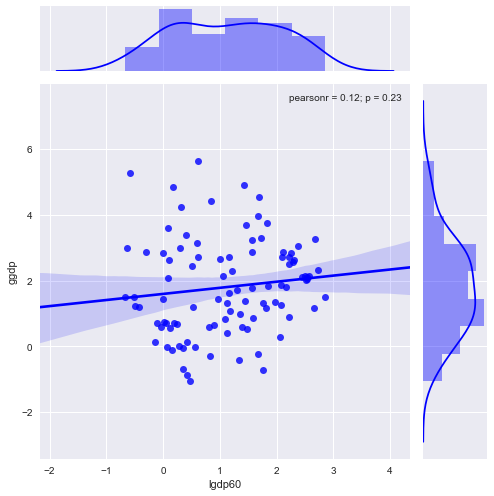

In [38]:
g = sns.jointplot("lgdp60", "ggdp", data=df, kind="reg",
                  color ="b", size=7)

#### Interactive plots

There are ways to make plots like these interactive.  
* On the next slide I use [ipywidgets](https://github.com/ipython/ipywidgets):  When the notebook is run on a jupyter server 'radio buttons' above the plot allow quick re-plotting for selected country regions. 

* Other libraries such as [Bokeh](http://bokeh.pydata.org/) and [Plotly](https://plot.ly/) create plots with embedded javascript code that allow interactive plot elements even on HTML renderings (i.e. in most browsers even if you do not have a jupyter server running).


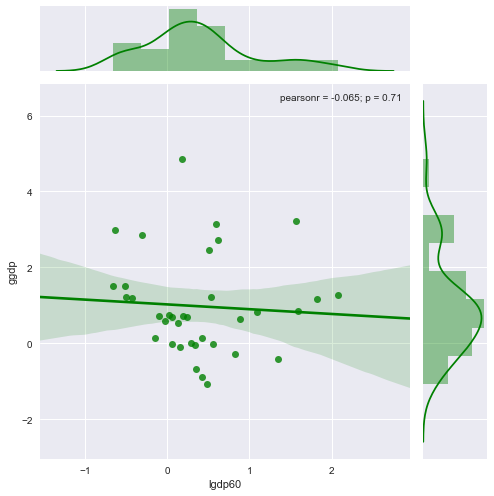

In [39]:
from ipywidgets import interact, FloatSlider, RadioButtons
region_buttons = RadioButtons(options=
        ['Africa', 'Europe & N. America', 'Asia','S. America'])
@interact(region=region_buttons)
def jplot(region):
    sns.jointplot("lgdp60", "ggdp", data=df[df.cont == region], 
                  kind="reg", color ="g", size=7)

In [45]:
from ipywidgets import *

from IPython.display import display

from IPython.html import widgets

In [46]:

from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [47]:
def f(x):
    return x

In [48]:

interact(f, x=10)